In [1]:
# import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
import scipy.sparse

In [55]:
# matplotlib parameters 
large = 40; med = 60; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams['text.usetex'] = True # need LaTeX. Change it to False if LaTeX is not installed in the system
plt.rcParams.update(params)

## Source well parameters

In [3]:
PI = np.pi
H_BAR = 6.626*10**(-34)/(2*PI)

r""" Rb87 parameters """
M   = 1.4192261*10**(-25) # kg
a_s = 98.006*5.29*10**(-11) # m https://journals.aps.org/pra/abstract/10.1103/PhysRevA.87.053614
trap_frequency = 918 # Hz
omega_x = trap_frequency
trap_length = np.sqrt(H_BAR/(M*trap_frequency)) # m
A = PI*trap_length**2 # m*m

N_atom = 20000

# interaction strength in the source well.
g_source   = (4*PI*H_BAR**2*a_s)/(A*M)
a_0 = np.sqrt(H_BAR/(trap_frequency*M))
#x_s = a_0
x_s = (4*np.pi*a_s*N_atom*a_0**4)**(1/5)    

epsilon = (H_BAR/(M*omega_x*x_s**2))
print(epsilon)
delta   = (g_source*N_atom*(x_s**2))/(a_0**3*H_BAR*omega_x)
print(delta)

0.05440717545239947
8473.31783134363


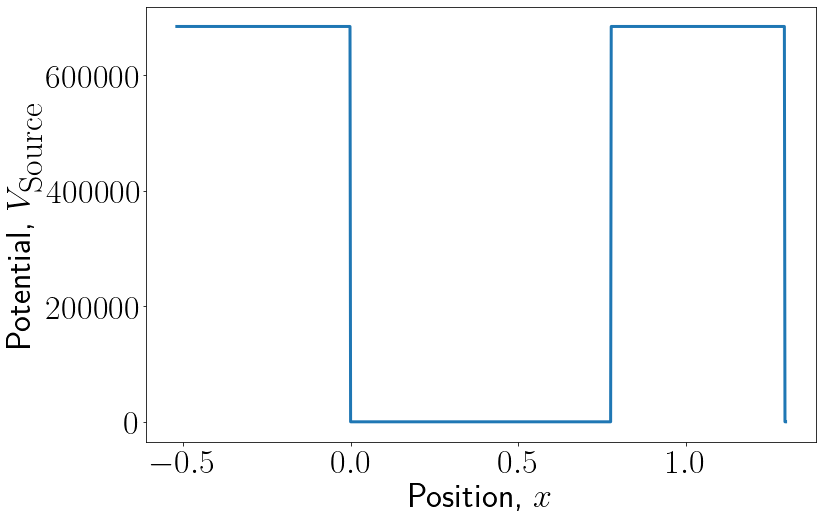

In [4]:
# number of discretized intervals in the position array
N = 2**10 # choose a power of two to make things simpler for fast Fourier transform

# barrier height outside the trap.
infinite_barrier_height = 10**5*10**3*2*PI*H_BAR


position_start = -2*1.e-6/x_s # m
position_end   = 5*1.e-6/x_s # m

dx = (position_end-position_start)/N

source_well_bias_potential = 0*10**3*2*PI*H_BAR

source_well_start          = 0*1.e-6/x_s # m
source_well_end            = 3*1.e-6/x_s # m

position_arr  = np.linspace(position_start,position_end,N)

r"""

We will start with a potential array with zeroes then gradually fill it up with
position and potential values mentioned above.

"""
potential_arr = np.zeros(N)

# calculates the number of points between the start of the position to the start of the source well
# and fills the potential array with corresponding potential values.
N_barrier_to_source_start = int(abs(source_well_start - position_start)/dx)
# sets the infinite potential in the source well.
for i in range(N_barrier_to_source_start):
    potential_arr[i] = infinite_barrier_height
    
N_source_start_to_source_end = N_barrier_to_source_start+int(abs(source_well_end - source_well_start)/dx)
# sets the source well bias potential.
for i in range(N_barrier_to_source_start,N_source_start_to_source_end):
    potential_arr[i] = source_well_bias_potential   
    
N_source_well_end_to_position_end = N_source_start_to_source_end + int(abs(position_end-source_well_end)/dx)
for i in range(N_source_start_to_source_end,N_source_well_end_to_position_end):
    potential_arr[i] = infinite_barrier_height    

f = plt.figure()    

# changing potential into dimensionless unit
potential_arr = potential_arr/(epsilon*M*omega_x**2*x_s**2)

plt.plot(position_arr,potential_arr,linewidth=3)
plt.xlabel(r"Position, $x$")
plt.ylabel(r"Potential, $V_{\textrm{Source}}$")
f.set_figwidth(12)
f.set_figheight(8)
plt.show()

## time split code

In [5]:
# discretizing the momentum space
L  = (position_end-position_start)
dk = (2*PI)/L

# Total Hamiltonian H = H(k) + H(x) = momentum space part + real space part
def Hamiltonian_x(position_array,potential_array,psi): # H(x)
    return potential_array/(epsilon*M*omega_x**2*x_s**2)+delta*epsilon**(3/2)*np.abs(psi)**2

# momentum space discretization.
k = np.hstack([np.arange(0,N/2), np.arange(-N/2,0)])*dk
E_k = k**2*epsilon/2

# Normalize the wavefunction in real space.
def normalize_x(wavefunction_x):
    return wavefunction_x/(np.sqrt(np.sum(np.abs(wavefunction_x)**2)*dx))

# Normalize the wavefunction in momentum space.
def normalize_k(wavefunction_k):
    return wavefunction_k/(np.sqrt(np.sum(np.abs(wavefunction_k)**2)*dk))

    
def time_split_suzukui_trotter(initial_wavefunction,position_array,potential_array,dt,total_time):    

    psi_k = fftpack.fft(initial_wavefunction)
    psi_x = initial_wavefunction
    
    total_iterations = int(np.abs(total_time)/np.abs(dt))
    print("Number of iterations =", total_iterations)
    
    for _ in range(total_iterations):

        # TVT
        # evolution in k space
        psi_k = np.exp(-(E_k * 1j*dt)/2) * psi_k
        
        psi_x = fftpack.ifft(psi_k)
        # evolution in x space
        psi_x = np.exp(-Hamiltonian_x(position_array,potential_array,psi_x) * 1j*dt) * psi_x
        
        psi_x = normalize_x(psi_x)  # normalizing          
        psi_k = fftpack.fft(psi_x)
        # evolution in k space
        psi_k = np.exp(-(E_k * 1j*dt)/2) * psi_k
        
        psi_x = fftpack.ifft(psi_k)
        psi_x = normalize_x(psi_x) # normalizing
        
        psi_k = fftpack.fft(psi_x)
    

    psi_x = normalize_x(psi_x) # returns the normalized wavefunction
    
    return psi_x

## ground state wavefunction  in the source well

In [6]:
# start with an initial state
psi_initial = np.ones(N)
psi_initial = normalize_x(psi_initial) 

# wavefunction is evolved in imaginary time to get the ground state
final_time_SI = 0.1
time_step_SI  = -1j*10**(-7)   
final_time = omega_x*final_time_SI
time_step = omega_x*time_step_SI
psi_ITE = time_split_suzukui_trotter(psi_initial,position_arr,potential_arr,time_step,final_time);
print("Normalization of the wavefucntion = ",np.sqrt(np.sum(np.abs(psi_ITE)**2)*dx) )

Number of iterations = 1000000
Normalization of the wavefucntion =  1.0


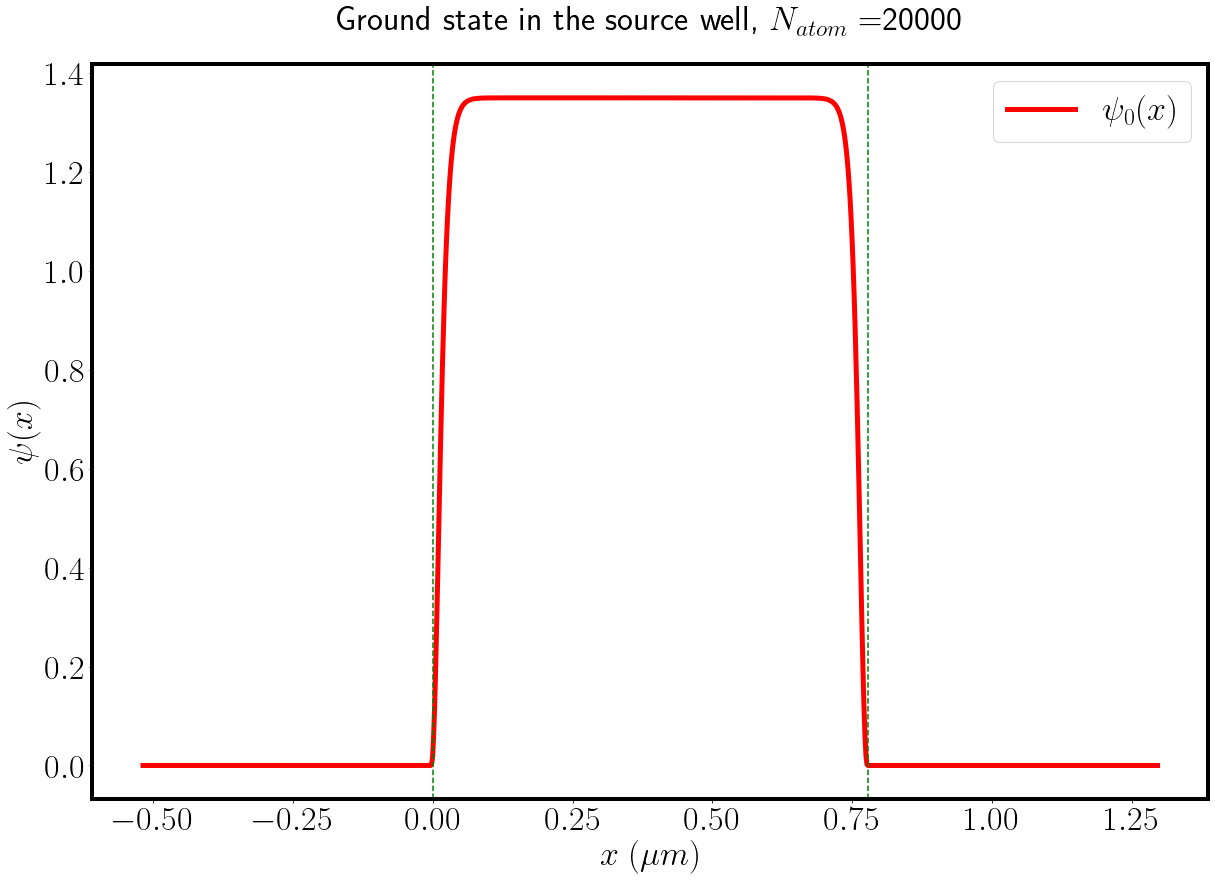

In [7]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)
plt.plot(position_arr,np.abs(psi_ITE)**2,label="$\psi_{0}(x)$",linewidth=5,color="red")
plt.legend()
plt.title("Ground state in the source well, "+"$N_{atom} = $"+str(N_atom))
plt.ylabel(r"$\psi(x)$")
plt.xlabel(r"$x\; (\mu m)$" )
ax = f.gca()
ax.axvline(0.0/x_s, color="green",label = r"Infinite well boundary",linestyle="--")
ax.axvline(source_well_end, color="green",label = r"Infinite well boundary",linestyle="--")
for spine in ax.spines.values():
    spine.set_linewidth(4)
plt.gcf().subplots_adjust(bottom=0.2)
#plt.xlim([0.0-0.05,source_well_end+0.05])
#plt.savefig("ground_state_in_source_well_imaginary_time_evolution.jpg", dpi=300)
#print("Normalization of the wavefunction = ",np.sum(np.abs(psi_ITE)**2)*dx)
plt.show()

In [8]:
"""f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)
plt.plot(position_arr,np.abs(psi_ITE/np.sqrt(x_s))**2,label="$\psi_{0}(x)$",linewidth=5,color="red")
plt.legend()
plt.title("Ground state in the source well, "+"$N_{atom} = $"+str(N_atom))
plt.ylabel(r"$\psi(x)$")
plt.xlabel(r"$x\; (\mu m)$" )
ax = f.gca()
ax.axvline(0.0/x_s, color="green",label = r"Infinite well boundary",linestyle="--")
ax.axvline(source_well_end, color="green",label = r"Infinite well boundary",linestyle="--")
for spine in ax.spines.values():
    spine.set_linewidth(4)
plt.gcf().subplots_adjust(bottom=0.2)
plt.xlim([0.0-0.05,source_well_end+0.05])
plt.tick_params(axis="x", direction="inout", length=20, width=3, color="k")
plt.tick_params(axis="y", direction="inout", length=20, width=3, color="k")
#plt.savefig("ground_state_in_source_well_imaginary_time_evolution.jpg", dpi=300)
#print("Normalization of the wavefunction = ",np.sum(np.abs(psi_ITE)**2)*dx)
plt.show()""";

## transistor potential for time split

In [20]:
# height of the infinite barrier in the source and the drain well.
infinite_barrier_height = 10**40*10**3*2*PI*H_BAR

position_start = -2*1.e-6/x_s # this must be same as the position start used earlier in the source well
position_end   = 12*1.e-6/x_s # right end of the transistor potential

# dx must be constant throught the code
N = int((position_end-position_start)/dx) # number of points in the discretized position
print(" Number of divisions in position, N = ",N,"\n")

source_well_bias_potential = 0       # must be same as the source well used earlier
source_well_start          = 0*1.e-6/x_s # must be same as the source well used earlier
source_well_end            = 3*1.e-6/x_s # must be same as the source well used earlier

source_gate_barrier_start  = source_well_end
source_gate_barrier_end    = 3.3*1.e-6/x_s

gate_bias_potential        = 0
gate_well_start            = source_gate_barrier_end
gate_well_end              = 4.5*1.e-6/x_s

gate_drain_barrier_start   = gate_well_end
gate_drain_barrier_end     = 4.8*1.e-6/x_s

drain_well_start           = gate_drain_barrier_end
drain_well_end             = 10*1.e-6/x_s

SG_barrier_height = 31*10**3*2*PI*H_BAR
GD_barrier_height = 32*10**3*2*PI*H_BAR

# creates the position array as an equally spaced array.
source_gate_drain_well_position = np.linspace(position_start,position_end,N)
# start with a zero initialized position array of length N.
source_gate_drain_well_potential = np.zeros(N)

# calculates the number of points between the start of the position to the start of the source well.
N_barrier_to_source_start = int(abs(source_well_start - position_start)/dx)
# sets the infinite potential in the source well.
for i in range(N_barrier_to_source_start):
    source_gate_drain_well_potential[i] = infinite_barrier_height
    
N_source_start_to_source_end = N_barrier_to_source_start+int(abs(source_well_end - source_well_start)/dx)
# sets the source well bias potential.
for i in range(N_barrier_to_source_start,N_source_start_to_source_end):
    source_gate_drain_well_potential[i] = source_well_bias_potential   
    
N_source_well_end_to_gate_well_start = N_source_start_to_source_end+int(abs(gate_well_start-source_well_end)/dx)
# sets the step barrier between the source and the gate well.
for i in range(N_source_start_to_source_end,N_source_well_end_to_gate_well_start):
    source_gate_drain_well_potential[i] = SG_barrier_height
    
N_gate_start_to_gate_end = N_source_well_end_to_gate_well_start+int(abs(gate_well_end-gate_well_start)/dx)
# sets the gate well potential.
for i in range(N_source_well_end_to_gate_well_start,N_gate_start_to_gate_end):
    source_gate_drain_well_potential[i] = gate_bias_potential

N_gate_end_to_drain_well_start = N_gate_start_to_gate_end+int(abs(drain_well_start-gate_well_end)/dx)
# sets the barrier between the gate and the drain well.
for i in range(N_gate_start_to_gate_end,N_gate_end_to_drain_well_start):
    source_gate_drain_well_potential[i] = GD_barrier_height

N_drain_start_to_drain_well_end = N_gate_end_to_drain_well_start+int(abs(drain_well_end-drain_well_start)/dx)
# sets the gate well potential values.
for i in range(N_gate_end_to_drain_well_start,N_drain_start_to_drain_well_end):
    source_gate_drain_well_potential[i] = 0 # drain well is always at zero potential.

N_drain_end_to_barrier = N_drain_start_to_drain_well_end+int(abs(position_end-drain_well_end)/dx)
# sets the infinite barrier after the drain well ends.
for i in range(N_drain_start_to_drain_well_end,N_drain_end_to_barrier):
        source_gate_drain_well_potential[i] = infinite_barrier_height       

# making the potential dimensionless       
#source_gate_drain_well_potential = source_gate_drain_well_potential/(epsilon*M*omega_x**2*x_s**2)   

 Number of divisions in position, N =  2048 



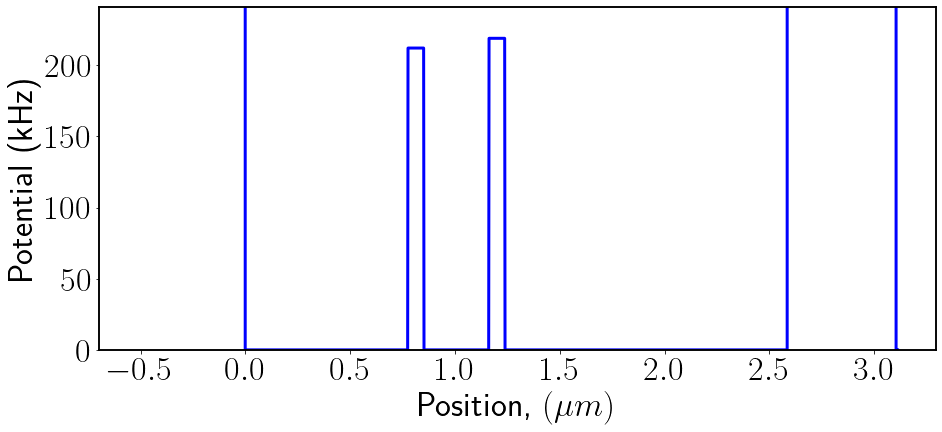

In [31]:
f = plt.figure()
plt.plot(source_gate_drain_well_position,source_gate_drain_well_potential/(epsilon*M*omega_x**2*x_s**2),linewidth=3,color="b")
plt.xlabel(r"Position, $(\mu  m)$")
plt.ylabel(r"Potential (kHz)")
plt.ylim([0,GD_barrier_height/(epsilon*M*omega_x**2*x_s**2)*1.1])
f.set_figwidth(15)
f.set_figheight(7)
ax = f.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.9)
plt.gcf().subplots_adjust(bottom=0.2)
#plt.savefig('transistor_potential_step_gate_well_infinite_barrier.jpg', dpi=600)
plt.show() 

# time split to evolve the wavefunction in real time

In [25]:
# momentum space discretization
k = np.hstack([np.arange(0,N/2), np.arange(-N/2,0)])*dk
if len(k) != N: # this is not necessary if N is even
    k = np.hstack([np.arange(0,N/2), np.arange(-N/2+1,0)])*dk
E_k = k**2*epsilon/2

# put the initial ground state in the source well of the transistor.
psi_initial_for_full_potential = psi_ITE
while len(psi_initial_for_full_potential) < N:
    psi_initial_for_full_potential = np.hstack((psi_initial_for_full_potential,np.array([0])))
    

final_time_SI = 0.5*10**(-3)
time_step_SI  = 10**(-8)    
final_time = omega_x*final_time_SI
time_step = omega_x*time_step_SI
time_evolved_wavefunction_time_split = time_split_suzukui_trotter(psi_initial_for_full_potential,
                                        source_gate_drain_well_position,source_gate_drain_well_potential,
                                        time_step,final_time)

Number of iterations = 50000


In [26]:
print("Normalization of the time evolved wavefunction = ",np.sum(np.abs(time_evolved_wavefunction_time_split)**2)*dx)

Normalization of the time evolved wavefunction =  1.0


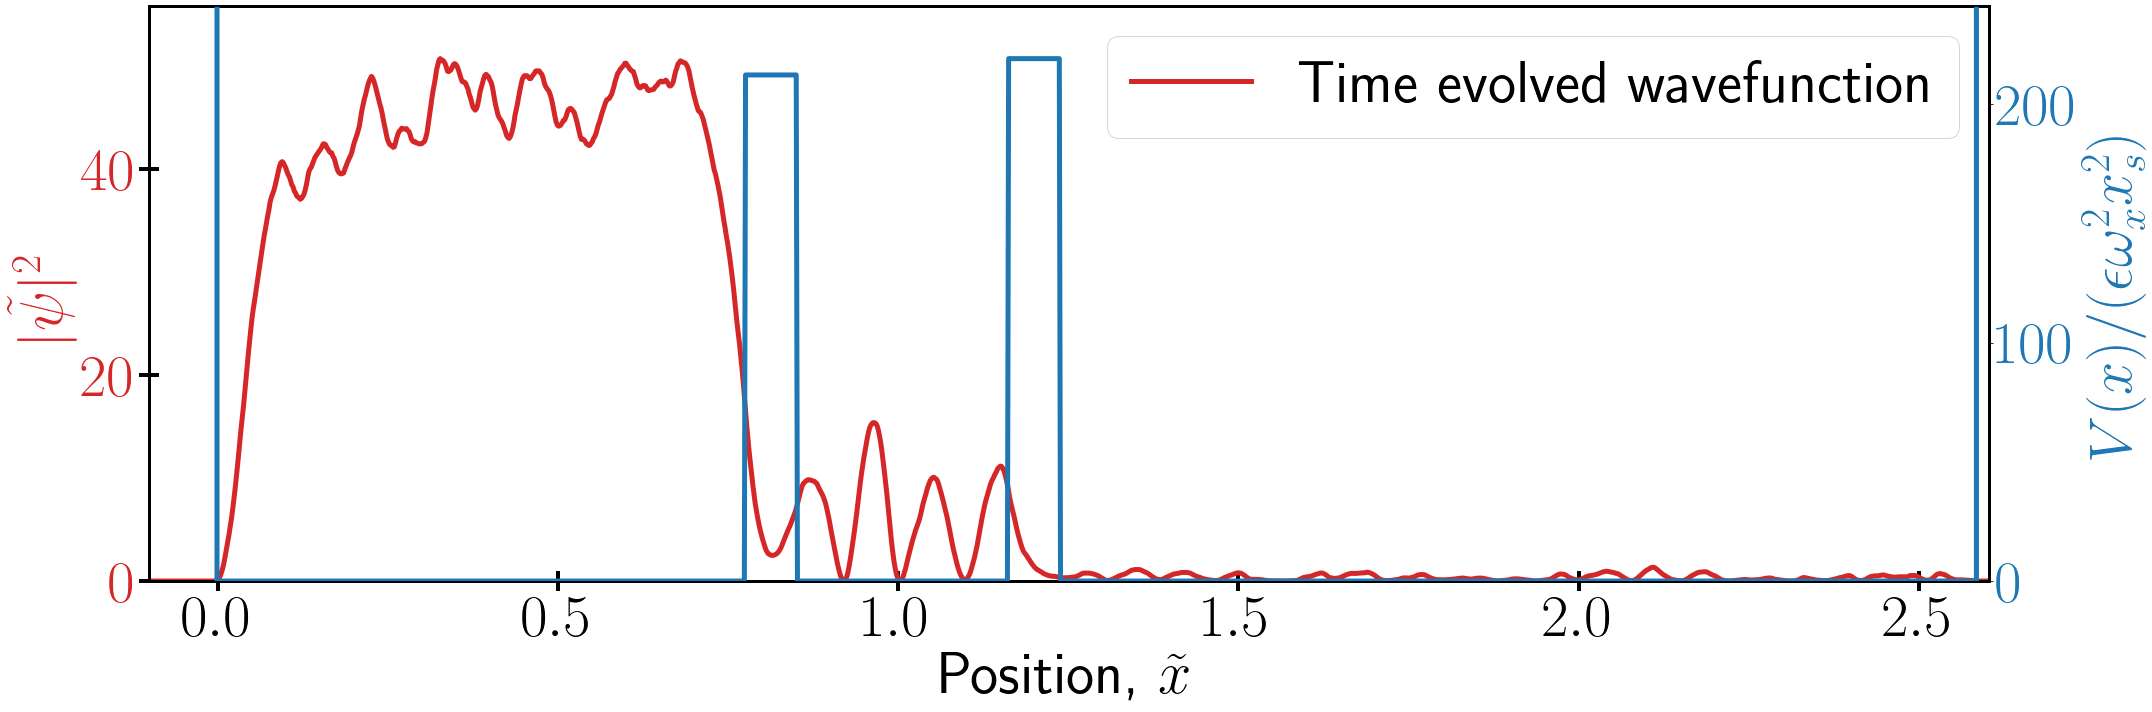

In [66]:
data0 = source_gate_drain_well_position
data1 = N_atom*np.abs(time_evolved_wavefunction_time_split)**2*dx
#data2 = np.abs(time_evolved_wavefunction_time_split)**2
data3 = source_gate_drain_well_potential/(epsilon*M*omega_x**2*x_s**2)

fig, ax1 = plt.subplots()

ax1.set_xlabel(r"Position, $\tilde{x}$")
ax1.set_ylabel(r"$|\tilde{\psi}|^{2}$", color="tab:red")
#ax1.scatter(t, data1, color=color,s= 5,linewidth = 3,label=r"Time = ")
#ax1.plot(data0, data2, color="tab:red",linewidth = 3,label=r"Time split")
ax1.plot(data0, data1, color="tab:red",linewidth = 5,label=r"Time evolved wavefunction")
plt.legend()
ax1.set_xlim([-0.1, drain_well_end+0.01]) 
ax1.set_ylim([0, np.max(data1)*1.1])
ax1.tick_params(axis='y', labelcolor="tab:red")
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel(r"$V(x)/(\epsilon \omega^{2}_{x} x^{2}_{s})$ ", color=color)  # we already handled the x-label with ax1
ax2.plot(data0, data3, color=color,linewidth = 5)
ax2.set_ylim([0, GD_barrier_height/(epsilon*M*omega_x**2*x_s**2)*1.1])
ax2.tick_params(axis="y", labelcolor=color)
fig.set_figwidth(30)
fig.set_figheight(10)
plt.subplots_adjust(bottom=0.2)
for spine in ax1.spines.values():
    spine.set_linewidth(3)
ax1.tick_params(axis="x", direction="inout", length=20, width=4, color="k")
ax1.tick_params(axis="y", direction="inout", length=20, width=4, color="k")
#plt.savefig("psi_"+str(N_atom)+"_"+str(i)+".jpg", dpi=600)
fig.tight_layout()

In [28]:
np.sum(N_atom*np.abs(time_evolved_wavefunction_time_split)**2*dx)

20000.0

In [35]:
# function to calculate the number of atoms in each well
def number_of_atom(wavefunction,a,b):
    psi_lst = []
    for i in range(N):
        if a <= source_gate_drain_well_position[i] <= b:
            psi_lst.append(wavefunction[i])
    return N_atom*np.sum(np.abs(psi_lst)**2)*dx

In [36]:
r"""

Number of atoms in each well calculated using time split wavefunction.

"""

print("Number of atoms in source well =",
      number_of_atom(time_evolved_wavefunction_time_split,source_well_start ,source_gate_barrier_start))
print("Number of atoms in gate well =",
      number_of_atom(time_evolved_wavefunction_time_split,gate_well_start ,gate_well_end))
print("Number of atoms in drain well =",
      number_of_atom(time_evolved_wavefunction_time_split,drain_well_start ,drain_well_end))

Number of atoms in source well = 18248.857963592996
Number of atoms in gate well = 1164.425445500525
Number of atoms in drain well = 273.2293241981963


## 